In [14]:
# 임포트, 설정 및 유틸리티
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import pandas as pd

# ---------- 유틸리티 함수들 ----------

def draw_ellipse(position, covariance, ax=None, nsig_levels=(1, 2, 3), **kwargs):
    """2차원 가우시안의 공분산 타원(들)을 그립니다."""
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    for nsig in nsig_levels:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, fill=False, **kwargs))

def generate_quadratic_data(n_samples=100, x_min=-10.0, x_max=15.0, noise_std=0.0, seed=42):
    """y = x^2 - 2x + 3에서 샘플링한 점들을 생성합니다. (필요 시 y에 가우시안 노이즈 추가)"""
    rng = np.random.default_rng(seed)
    x = np.linspace(x_min, x_max, n_samples)
    y = x**2 - 2 * x + 3
    if noise_std > 0:
        y = y + rng.normal(0.0, noise_std, size=y.shape)
    data = np.column_stack([x, y])
    return data, x, y

def fit_gmm_range(X, n_components_range, random_state=42):
    """여러 컴포넌트 수로 GMM을 학습하고 AIC/BIC 점수를 계산합니다."""
    models, aic_scores, bic_scores = [], [], []
    for k in n_components_range:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(X)
        models.append(gmm)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
    return models, np.array(aic_scores), np.array(bic_scores)

def plot_bic_aic(n_components_range, bic_scores, aic_scores, best_k, ax=None):
    """컴포넌트 수에 따른 BIC/AIC 곡선을 시각화합니다."""
    ax = ax or plt.gca()
    ax.plot(n_components_range, bic_scores, 'bo-', label='BIC')
    ax.plot(n_components_range, aic_scores, 'ro-', label='AIC')
    ax.axvline(best_k, color='green', linestyle='--', label=f'Best n_components = {best_k}')
    ax.set_title('2. BIC & AIC vs Number of Components', fontsize=13)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Information criterion')
    ax.legend()


def plot_gmm_clusters(X, gmm, ax=None):
    """GMM 클러스터링 결과와 각 컴포넌트의 공분산 타원을 함께 그립니다."""
    ax = ax or plt.gca()
    y_pred = gmm.predict(X)
    K = gmm.n_components
    for i in range(K):
        ax.scatter(X[y_pred == i, 0], X[y_pred == i, 1], s=10, label=f'Cluster {i+1}')
        draw_ellipse(gmm.means_[i], gmm.covariances_[i], ax=ax, color='gray', alpha=0.6, linewidth=1)
    ax.set_title(f'3. Best GMM Result (n_components = {gmm.n_components})', fontsize=13)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()


def plot_responsibilities_grid(X, gmm, cols=3):
    """각 컴포넌트에 대한 책임도(responsibility)를 그리드로 시각화합니다."""
    resp = gmm.predict_proba(X)
    K = gmm.n_components
    import math
    rows = math.ceil(K / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = np.array(axes).reshape(-1)

    # 여백 포함 범위 계산
    margin = 0.1
    xmin, xmax = X[:,0].min(), X[:,0].max()
    ymin, ymax = X[:,1].min(), X[:,1].max()
    xrng, yrng = xmax - xmin, ymax - ymin
    xmin -= margin * xrng; xmax += margin * xrng
    ymin -= margin * yrng; ymax += margin * yrng

    for k in range(K):
        ax = axes[k]
        gamma_k = resp[:, k]
        # 전체 데이터는 연한 회색으로 베이스 표시
        ax.scatter(X[:,0], X[:,1], s=8, color='lightgray', alpha=0.4, label='All data')
        # 책임도에 비례해 점 크기/색상으로 강조
        sizes = 10 + 90 * gamma_k
        sc = ax.scatter(X[:,0], X[:,1], c=gamma_k, s=sizes, cmap='viridis', alpha=0.85,
                        edgecolors='face', label=f'Comp {k+1} resp')
        cbar = plt.colorbar(sc, ax=ax, fraction=0.045, pad=0.02)
        cbar.set_label('Responsibility')
        # 평균 및 공분산 타원 표시
        draw_ellipse(gmm.means_[k], gmm.covariances_[k], ax=ax, color='red', alpha=0.7, linewidth=1)
        ax.scatter(gmm.means_[k][0], gmm.means_[k][1], c='red', marker='x', s=120, linewidth=2, label='Mean')
        ax.set_title(f'Component {k+1}')
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left', fontsize=9)

    # 남는 축 제거
    for j in range(K, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Responsibility and Ellipse per Component (K={K})', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


_TWO_PI = 2.0 * np.pi

def gaussian_pdf_grid(grid_points, mean, cov):
    """2차원 가우시안 PDF 값을 격자점에서 계산합니다."""
    d = mean.shape[0]
    cov_inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    norm_const = np.sqrt((_TWO_PI)**d * det)
    diff = grid_points - mean
    expo = -0.5 * np.sum((diff @ cov_inv) * diff, axis=1)
    return np.exp(expo) / norm_const


def plot_mixture_and_components_contours(X, gmm, cols=3, n_grid=160, margin=0.15):
    """혼합 PDF와 각 컴포넌트의 PDF를 컨투어로 시각화합니다."""
    K = gmm.n_components
    weights, means, covariances = gmm.weights_, gmm.means_, gmm.covariances_

    # 컨투어 그리드를 위한 범위 설정(여백 포함)
    xmin, xmax = X[:,0].min(), X[:,0].max()
    ymin, ymax = X[:,1].min(), X[:,1].max()
    xrng = xmax - xmin; yrng = ymax - ymin
    xmin -= margin * xrng; xmax += margin * xrng
    ymin -= margin * yrng; ymax += margin * yrng

    # 격자 생성
    xlin = np.linspace(xmin, xmax, n_grid)
    ylin = np.linspace(ymin, ymax, n_grid)
    Xg, Yg = np.meshgrid(xlin, ylin)
    grid_points = np.column_stack([Xg.ravel(), Yg.ravel()])

    # 각 컴포넌트의 PDF 및 혼합 PDF 계산
    component_pdfs = []
    for k in range(K):
        pdf_k = gaussian_pdf_grid(grid_points, means[k], covariances[k]).reshape(n_grid, n_grid)
        component_pdfs.append(pdf_k)
    component_pdfs = np.array(component_pdfs)
    mixture_pdf = np.tensordot(weights, component_pdfs, axes=(0, 0))

    # 레이아웃 구성
    import math
    rows = math.ceil((K + 1) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = np.array(axes).reshape(-1)

    # 공통 레벨 설정
    max_val = max(mixture_pdf.max(), component_pdfs.max())
    levels = np.linspace(0, max_val, 14)

    # 혼합 PDF
    ax0 = axes[0]
    cf = ax0.contourf(Xg, Yg, mixture_pdf, levels=levels, cmap='magma')
    ax0.contour(Xg, Yg, mixture_pdf, levels=levels[::2], colors='k', alpha=0.4, linewidths=0.6)
    ax0.scatter(X[:,0], X[:,1], s=6, c='white', alpha=0.5, edgecolors='none')
    ax0.set_title(f'Mixture PDF (K={K})')
    ax0.set_xlim(xmin, xmax); ax0.set_ylim(ymin, ymax)
    ax0.grid(alpha=0.2)
    plt.colorbar(cf, ax=ax0, fraction=0.045, pad=0.02).set_label('Density')

    # 각 컴포넌트 PDF
    for k in range(K):
        ax = axes[k+1]
        pdf_k = component_pdfs[k]
        cfk = ax.contourf(Xg, Yg, pdf_k, levels=levels, cmap='viridis')
        ax.contour(Xg, Yg, pdf_k, levels=levels[::2], colors='k', alpha=0.35, linewidths=0.5)
        draw_ellipse(means[k], covariances[k], ax=ax, color='red', alpha=0.8, linewidth=1)
        ax.scatter(means[k][0], means[k][1], c='red', marker='x', s=110, linewidths=2)
        ax.set_title(f'Component {k+1} PDF\n(weight={weights[k]:.3f})')
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.grid(alpha=0.2)
        plt.colorbar(cfk, ax=ax, fraction=0.045, pad=0.02)

    # 남는 축 제거
    for j in range(K+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Mixture and Component 2D PDF Contours', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()


def summarize_gmm_components(gmm):
    """GMM 컴포넌트들의 평균/분산(공분산) 등의 요약 정보를 반환합니다."""
    K = gmm.n_components
    means = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_
    rows = []
    for k in range(K):
        mu = means[k]
        cov = covariances[k]
        var_x, var_y = np.diag(cov)
        corr = cov[0,1] / np.sqrt(var_x * var_y)
        rows.append({
            'Component': k+1,
            'Weight (pi_k)': weights[k],
            'Mean_x': mu[0],
            'Mean_y': mu[1],
            'Var_x': var_x,
            'Var_y': var_y,
            'Cov_xy': cov[0,1],
            'Corr_xy': corr,
            'Det|Σ|': np.linalg.det(cov)
        })
    return pd.DataFrame(rows).sort_values('Weight (pi_k)', ascending=False).reset_index(drop=True)


def sqrtm_2x2(mat):
    """2x2 대칭 양의 정부호(또는 준정부호) 행렬의 제곱근을 고유분해로 계산합니다."""
    vals, vecs = np.linalg.eigh(mat)
    vals_clipped = np.clip(vals, 0, None)
    return (vecs * np.sqrt(vals_clipped)) @ vecs.T


def sample_and_evaluate(X, gmm, bins=30, plot=True):
    """GMM에서 샘플링 후 원본과의 통계/분포 유사도를 계산합니다."""
    rng = np.random.default_rng(123)
    n_gen = X.shape[0]
    sampled_data, _ = gmm.sample(n_gen)

    # 1) 1~2차 모멘트 비교
    orig_mean = X.mean(axis=0)
    orig_cov = np.cov(X, rowvar=False)
    gen_mean = sampled_data.mean(axis=0)
    gen_cov = np.cov(sampled_data, rowvar=False)
    mean_diff = np.linalg.norm(orig_mean - gen_mean)
    cov_diff_fro = np.linalg.norm(orig_cov - gen_cov, ord='fro')

    # 2) Fréchet 거리(2D 가우시안 근사)
    sqrt_term = sqrtm_2x2(orig_cov @ gen_cov)
    frechet_dist = np.sum((orig_mean - gen_mean)**2) + np.trace(orig_cov + gen_cov - 2*sqrt_term)

    # 3) 로그우도 비교
    ll_orig = gmm.score_samples(X).mean()
    ll_gen = gmm.score_samples(sampled_data).mean()
    ll_gap = ll_orig - ll_gen

    # 4) 2D 히스토그램 기반 분포 차이
    xedges = np.linspace(X[:,0].min(), X[:,0].max(), bins+1)
    yedges = np.linspace(X[:,1].min(), X[:,1].max(), bins+1)
    H_orig, _, _ = np.histogram2d(X[:,0], X[:,1], bins=[xedges, yedges], density=True)
    H_gen,  _, _ = np.histogram2d(sampled_data[:,0], sampled_data[:,1], bins=[xedges, yedges], density=True)
    eps = 1e-12
    P = H_orig + eps; Q = H_gen + eps
    P /= P.sum(); Q /= Q.sum()
    l1_dist = np.abs(P - Q).sum()
    l2_dist = np.sqrt(((P - Q)**2).sum())
    M = 0.5 * (P + Q)
    jsd = 0.5 * ((P*np.log(P/M)).sum() + (Q*np.log(Q/M)).sum())

    # 시각화(옵션)
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        axes[0].scatter(X[:,0], X[:,1], s=20, alpha=0.7, label='Original', c='tab:blue')
        axes[0].set_title('Original Data')
        axes[0].grid(alpha=0.3)
        axes[1].scatter(sampled_data[:,0], sampled_data[:,1], s=20, alpha=0.7, label='Generated', c='tab:orange')
        axes[1].set_title('Generated (GMM Sample)')
        axes[1].grid(alpha=0.3)
        for ax in axes:
            ax.set_xlabel('X'); ax.set_ylabel('Y')
        plt.tight_layout(); plt.show()

    metrics = {
        'orig_mean': orig_mean, 'gen_mean': gen_mean, 'mean_l2_diff': float(mean_diff),
        'orig_cov': orig_cov, 'gen_cov': gen_cov, 'cov_fro_diff': float(cov_diff_fro),
        'frechet_distance': float(frechet_dist),
        'mean_loglik_orig': float(ll_orig), 'mean_loglik_gen': float(ll_gen), 'loglik_gap': float(ll_gap),
        'l1_distance': float(l1_dist), 'l2_distance': float(l2_dist), 'js_divergence': float(jsd)
    }
    return metrics


def em_visualize(X, K, max_iter=40, tol=1e-4):
    """EM 알고리즘 수렴 과정을 시각화합니다."""
    N, D = X.shape
    rng = np.random.default_rng(2024)
    # 초기화: 무작위로 선택한 점을 평균으로, 공분산은 전체 공분산 + 정규화항, 가중치는 균등
    init_indices = rng.choice(N, K, replace=False)
    means_em = X[init_indices].copy()
    overall_cov = np.cov(X, rowvar=False)
    reg_c = 1e-3
    covs_em = np.array([overall_cov + reg_c * np.eye(D) for _ in range(K)])
    weights_em = np.full(K, 1.0 / K)

    # 기록용 히스토리 (iteration 0은 초기)
    means_hist = [means_em.copy()]
    covs_hist = [covs_em.copy()]
    weights_hist = [weights_em.copy()]
    loglik_hist = []

    def gaussian_logpdf_local(X, mean, cov):
        diff = X - mean
        cov_inv = np.linalg.inv(cov)
        log_det = np.log(np.linalg.det(cov) + 1e-15)
        expo = -0.5 * np.sum((diff @ cov_inv) * diff, axis=1)
        return expo - 0.5 * (D * np.log(2 * np.pi) + log_det)

    for it in range(1, max_iter + 1):
        # E-step: 로그 책임도 계산
        log_prob = np.zeros((N, K))
        for k in range(K):
            log_prob[:, k] = np.log(weights_em[k] + 1e-15) + gaussian_logpdf_local(X, means_em[k], covs_em[k])
        # log-sum-exp 안정화
        max_lp = log_prob.max(axis=1, keepdims=True)
        log_sum = max_lp + np.log(np.sum(np.exp(log_prob - max_lp), axis=1, keepdims=True))
        log_resp = log_prob - log_sum
        resp = np.exp(log_resp)
        # 로그우도
        ll = np.sum(log_sum)
        loglik_hist.append(ll)

        # M-step: 파라미터 업데이트
        Nk = resp.sum(axis=0) + 1e-15
        weights_em = Nk / N
        means_em = (resp.T @ X) / Nk[:, None]
        for k in range(K):
            diff = X - means_em[k]
            cov_k = (resp[:, k][:, None] * diff).T @ diff / Nk[k]
            covs_em[k] = cov_k + reg_c * np.eye(D)

        means_hist.append(means_em.copy())
        covs_hist.append(covs_em.copy())
        weights_hist.append(weights_em.copy())

        # 수렴 체크
        if it > 1 and abs(loglik_hist[-1] - loglik_hist[-2]) < tol * (abs(loglik_hist[-2]) + 1e-12):
            print(f"[EM] Converged at iter {it} (loglik diff < tol)")
            break
    else:
        print("[EM] Reached max_iter")

    final_iter = len(means_hist) - 1
    print(f"Total recorded iterations: {final_iter}")

    # 표시할 iteration 선택
    import math
    candidate_iters = [0, 1, 2, 3, 5, 10, 15, final_iter]
    show_iters = [i for i in candidate_iters if i <= final_iter]

    # 색상 팔레트 및 레이아웃
    colors = plt.cm.tab10(np.linspace(0, 1, K))
    cols = 4
    rows = int(np.ceil(len(show_iters) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = np.array(axes).reshape(-1)

    # 축 범위
    xmin, xmax = X[:,0].min(), X[:,0].max()
    ymin, ymax = X[:,1].min(), X[:,1].max()
    mx = 0.1
    xpad = (xmax - xmin) * mx
    ypp = (ymax - ymin) * mx
    x_range = (xmin - xpad, xmax + xpad)
    y_range = (ymin - ypp, ymax + ypp)

    for ax, it in zip(axes, show_iters):
        ax.scatter(X[:,0], X[:,1], s=8, color='lightgray', alpha=0.5)
        m_it = means_hist[it]
        c_it = covs_hist[it]
        w_it = weights_hist[it]
        for k in range(K):
            draw_ellipse(m_it[k], c_it[k], ax=ax, color=colors[k], alpha=0.8, linewidth=1)
            ax.scatter(m_it[k,0], m_it[k,1], c=[colors[k]], s=60 + 400*w_it[k], marker='x', linewidths=2)
        title = f"Iter {it}"
        if it > 0 and it <= len(loglik_hist):
            title += f"\nLL={loglik_hist[it-1]:.1f}"
        ax.set_title(title)
        ax.set_xlim(*x_range); ax.set_ylim(*y_range)
        ax.grid(alpha=0.3)

    # 남는 축 제거
    for j in range(len(show_iters), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('GMM EM convergence (random init → optimum)', fontsize=18, y=1.02)
    plt.tight_layout(); plt.show()

    # 로그우도 진행 곡선
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(loglik_hist)+1), loglik_hist, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('EM Log-Likelihood Progress')
    plt.grid(alpha=0.3)
    plt.show()

    print('Shown iterations:', show_iters)
    print('Final log-likelihood:', loglik_hist[-1])

# ---------- 데이터 생성 ----------
np.random.seed(42)
data, X_func, Y_func = generate_quadratic_data(n_samples=100, x_min=-10, x_max=15, noise_std=0.0, seed=42)
print(f"Data shape: {data.shape}")

Data shape: (100, 2)


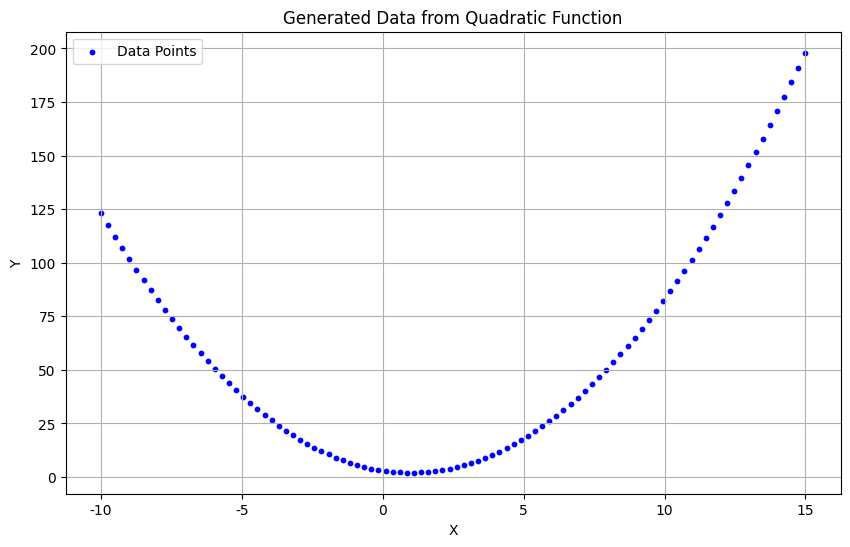

In [15]:
# 생성된 데이터 간단 확인
plt.figure(figsize=(10, 6))
plt.scatter(data[:,0], data[:,1], s=10, label='Data Points', color='blue')
plt.title('Generated Data from Quadratic Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(); plt.grid(True); plt.show()

In [16]:
# BIC 기준으로 가장 좋은 GMM 선택
n_components_range = range(1, 11)
gmm_models, aic_scores, bic_scores = fit_gmm_range(data, n_components_range)

best_idx = int(np.argmin(bic_scores))
best_gmm = gmm_models[best_idx]
best_n_components = best_gmm.n_components
print(f"Best number of components (by BIC): {best_n_components}")

Best number of components (by BIC): 9


In [17]:
# Select the model with the lowest BIC as best
best_gmm_index = np.argmin(bic_scores)
best_gmm = gmm_models[best_gmm_index]
best_n_components = best_gmm.n_components

print(f"Best number of components (by BIC): {best_n_components}")

Best number of components (by BIC): 9


In [18]:
best_gmm

,n_components,9
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


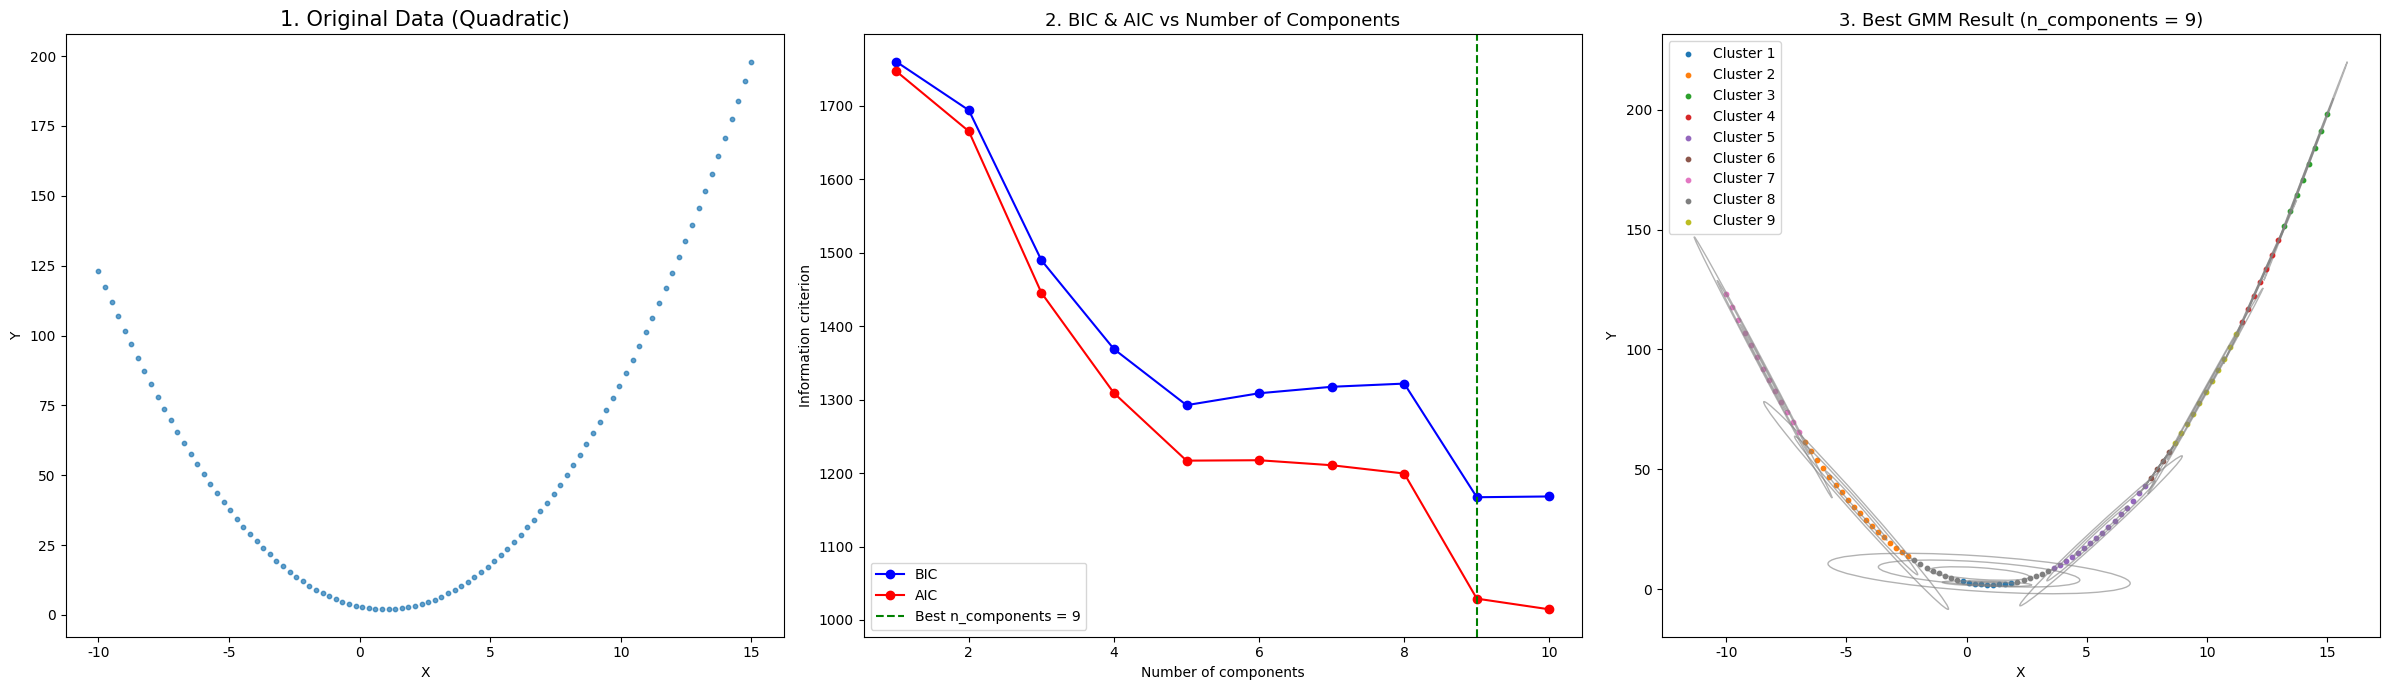

In [19]:
# 데이터, 기준(AIC/BIC), 최적 GMM 클러스터링 시각화
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
plt.rcParams['axes.unicode_minus'] = False

# 1) 원본 데이터
axes[0].scatter(data[:, 0], data[:, 1], s=10, alpha=0.7)
axes[0].set_title('1. Original Data (Quadratic)', fontsize=15)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# 2) AIC/BIC 곡선
plot_bic_aic(n_components_range, bic_scores, aic_scores, best_n_components, ax=axes[1])

# 3) 최적 GMM 결과
plot_gmm_clusters(data, best_gmm, ax=axes[2])

plt.tight_layout(); plt.show()

GMM은 2D 공간에서 여러 개의 타원형 가우시안으로 “곡선 모양의 밀도”를 분할해 근사함.

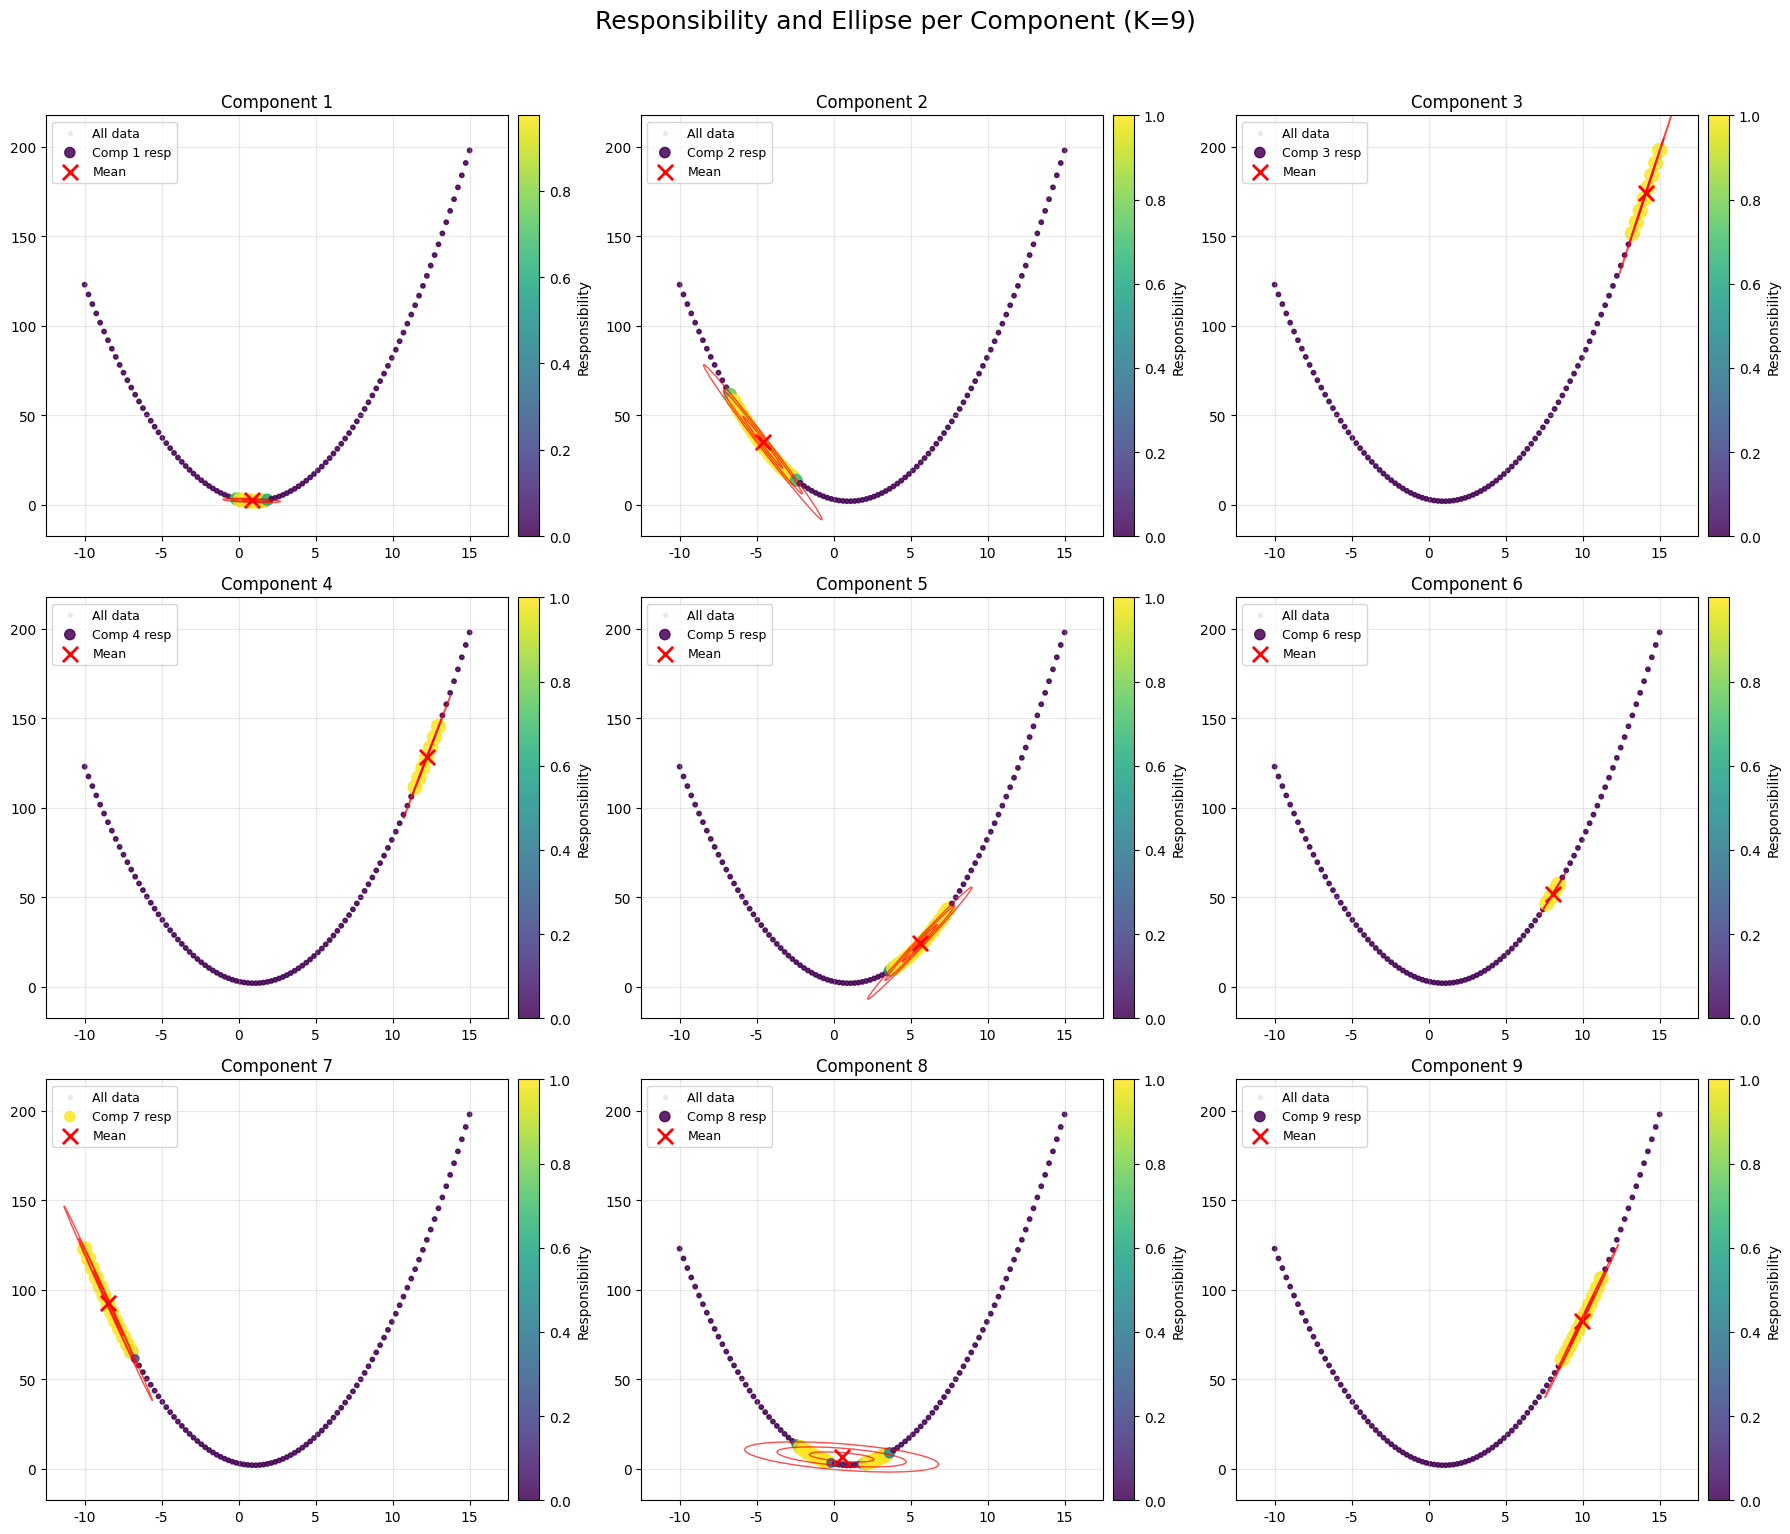

In [20]:
# Responsibilities per component
plot_responsibilities_grid(data, best_gmm, cols=3)

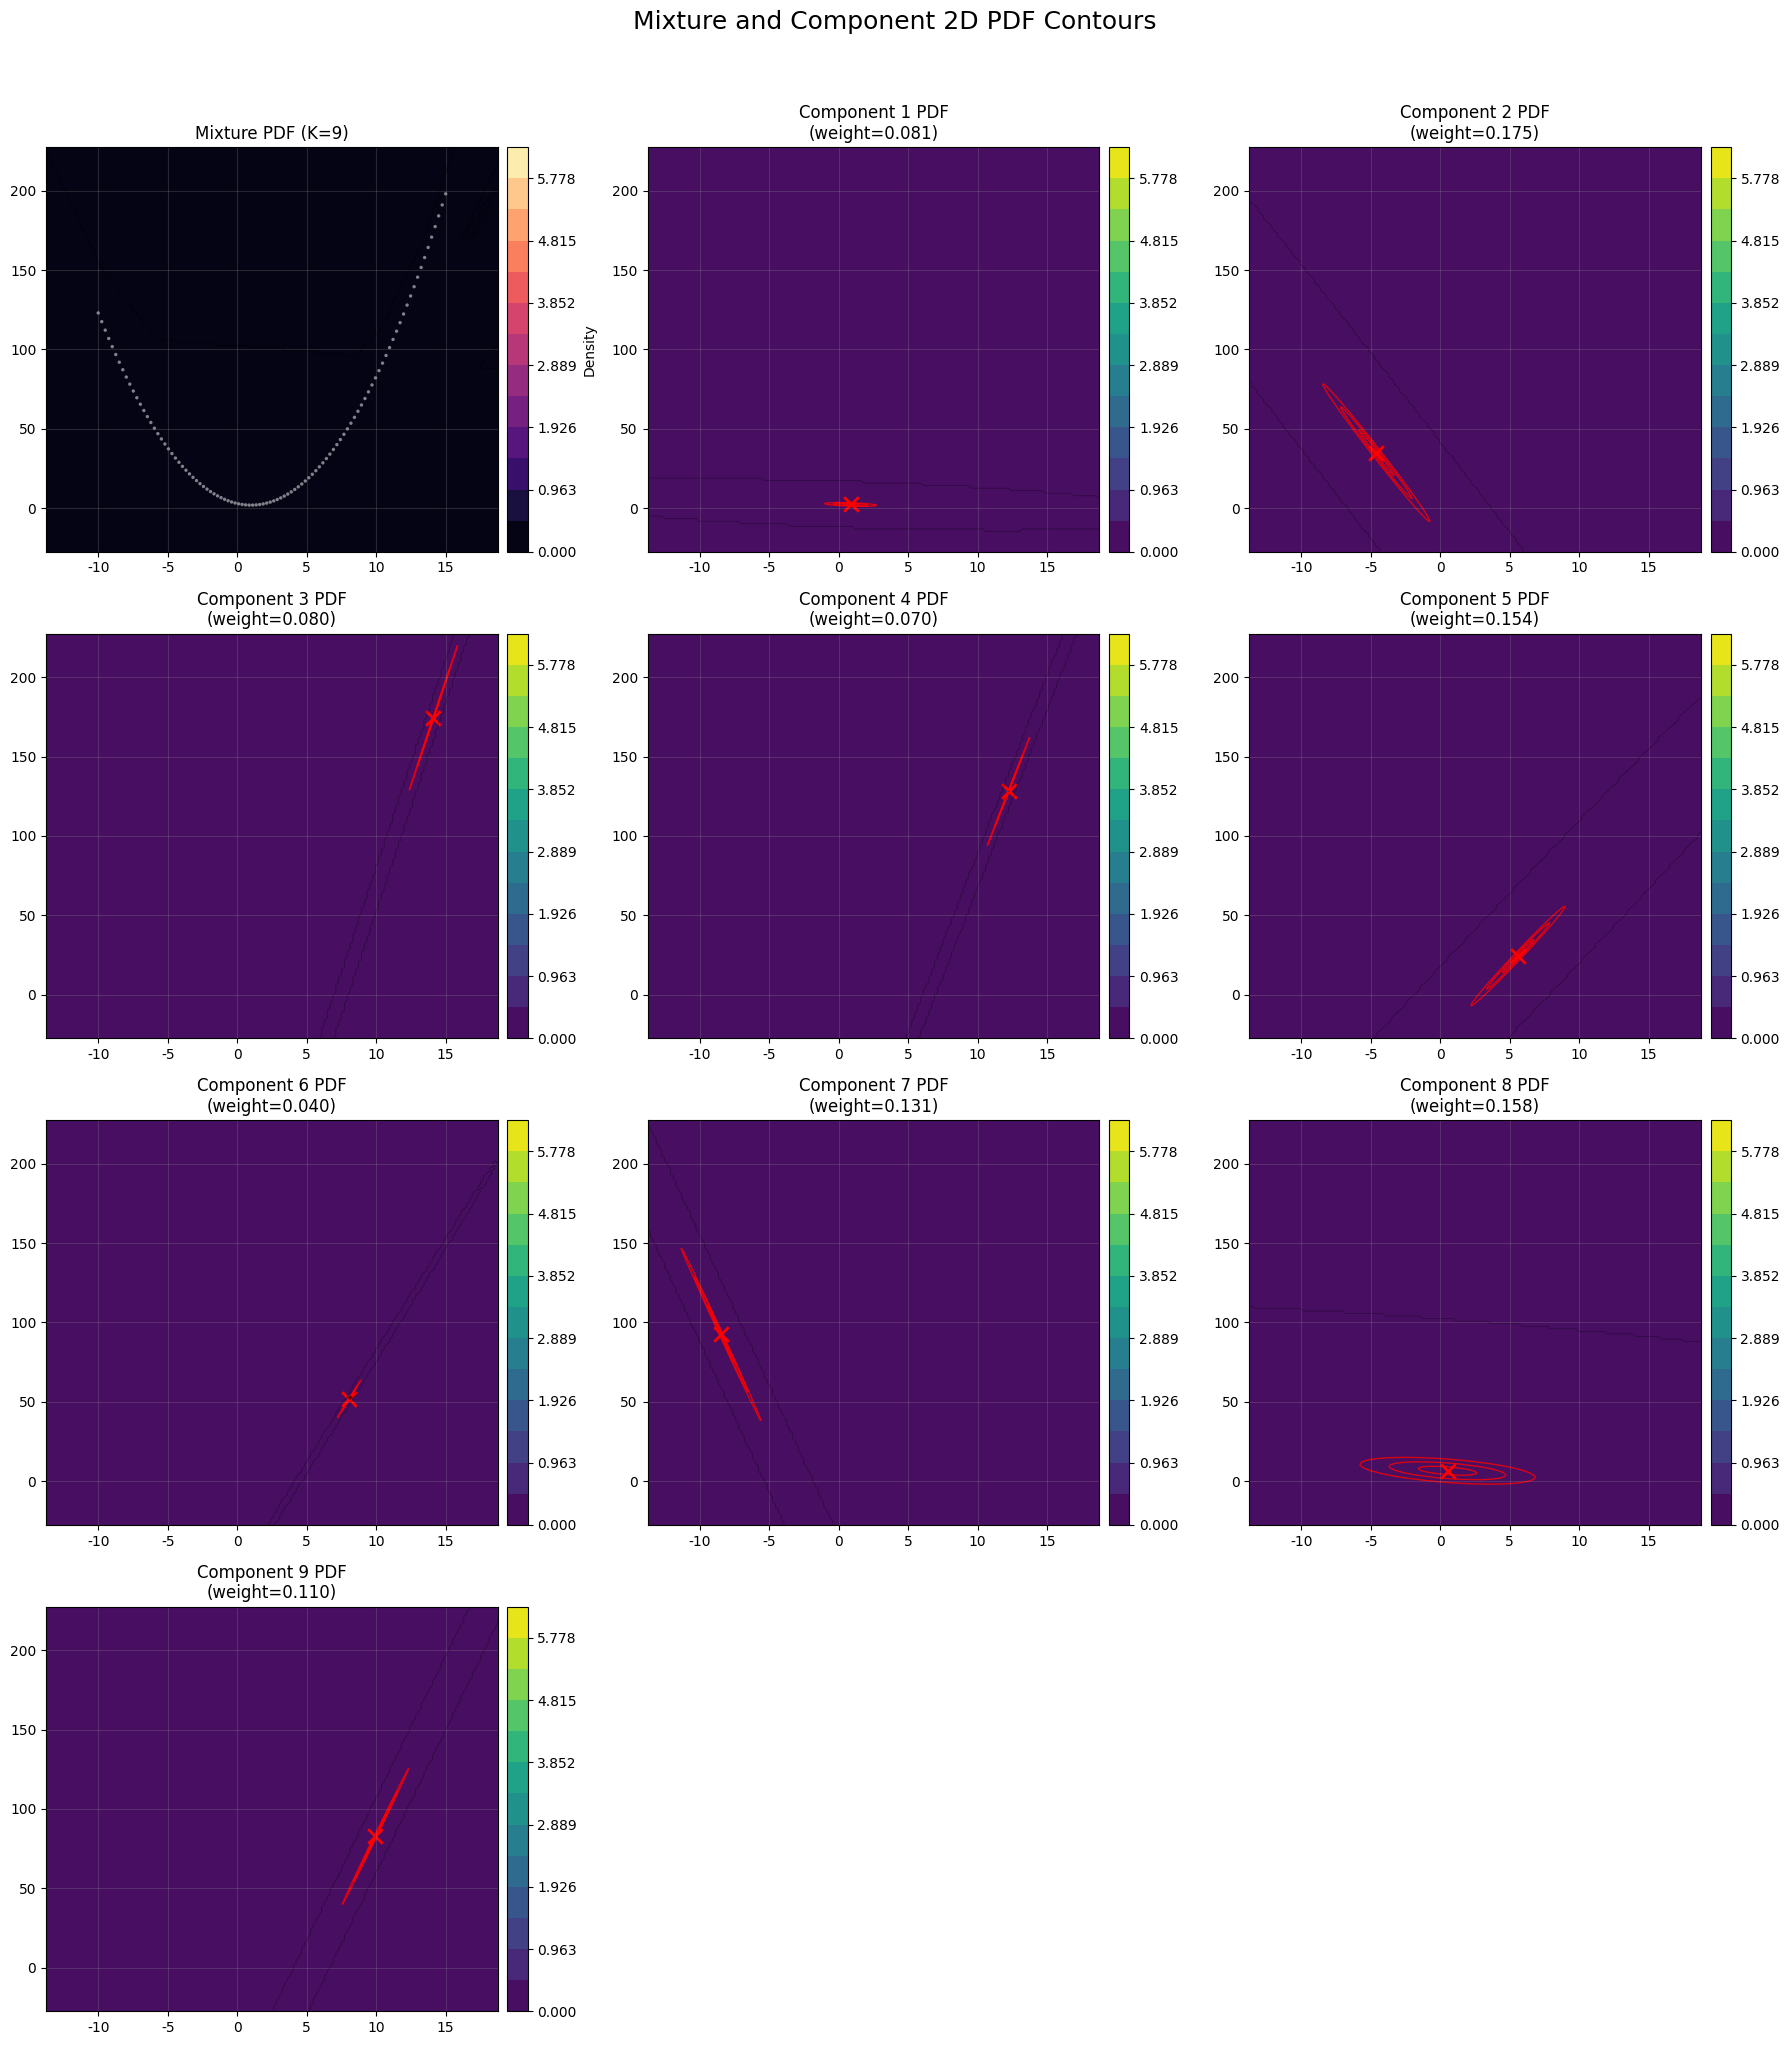

In [21]:
# Mixture and per-component 2D PDF contours
plot_mixture_and_components_contours(data, best_gmm, cols=3, n_grid=160, margin=0.15)

In [22]:
# Summarize GMM components
summary_df = summarize_gmm_components(best_gmm)
print(f"covariance_type = {getattr(best_gmm, 'covariance_type', 'unknown')}")
display(summary_df.round(5))

covariance_type = full


,Component,Weight (pi_k),Mean_x,Mean_y,Var_x,Var_y,Cov_xy,Corr_xy,Det|Σ|
0,2,0.17527,-4.59748,34.97686,1.64508,208.11888,-18.40468,-0.99467,3.63963
1,8,0.15793,0.52228,6.62460,4.39638,7.88841,-2.86181,-0.48596,26.49050
2,5,0.15432,5.59925,24.42494,1.27183,108.51687,11.67675,0.99394,1.66894
3,7,0.13126,-8.46707,92.54199,0.91663,328.87432,-17.34462,-0.99897,0.61954
4,9,0.10990,9.94822,82.70799,0.63728,204.46314,11.40606,0.99922,0.20281
5,1,0.08124,0.85107,2.40590,0.38372,0.15913,-0.11271,-0.45613,0.04836
6,3,0.07999,14.11608,174.36666,0.33506,230.63045,8.78895,0.99981,0.02898
7,4,0.07012,12.22061,128.15932,0.25712,129.51560,5.76957,0.99980,0.01312
8,6,0.03998,8.05554,51.86040,0.07970,15.87407,1.12465,0.99987,0.00034


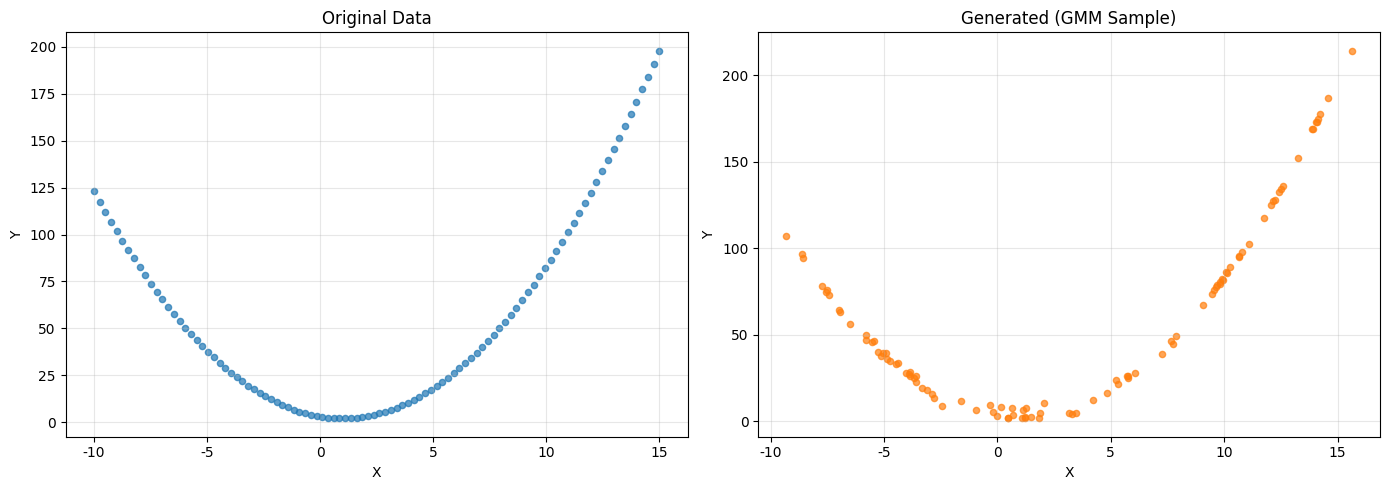

[Basic statistics]
Original mean: [ 2.5        57.38552189]
Generated mean: [ 2.90410125 58.41174742]
Mean L2 diff: 1.1029

Original cov:
 [[  53.67224433  161.01673299]
 [ 161.01673299 2763.8878444 ]]
Generated cov:
 [[  52.7762966   234.18176125]
 [ 234.18176125 2787.93364684]]
Cov Frobenius diff: 106.2320
Fréchet distance (Gaussian approx): 74.2667

[Log-likelihood]
Mean log-likelihood (original):  -4.6151
Mean log-likelihood (generated): -4.5123
Log-likelihood gap (orig - gen): -0.1028

[2D histogram divergence]
L1 distance: 0.8442
L2 distance: 0.1253
Jensen-Shannon divergence (approx): 0.177270


In [23]:
# Sample from best GMM and evaluate similarity to original data
metrics = sample_and_evaluate(data, best_gmm, bins=30, plot=True)

print('[Basic statistics]')
print('Original mean:', metrics['orig_mean'])
print('Generated mean:', metrics['gen_mean'])
print(f"Mean L2 diff: {metrics['mean_l2_diff']:.4f}")
print('\nOriginal cov:\n', metrics['orig_cov'])
print('Generated cov:\n', metrics['gen_cov'])
print(f"Cov Frobenius diff: {metrics['cov_fro_diff']:.4f}")
print(f"Fréchet distance (Gaussian approx): {metrics['frechet_distance']:.4f}")

print('\n[Log-likelihood]')
print(f"Mean log-likelihood (original):  {metrics['mean_loglik_orig']:.4f}")
print(f"Mean log-likelihood (generated): {metrics['mean_loglik_gen']:.4f}")
print(f"Log-likelihood gap (orig - gen): {metrics['loglik_gap']:.4f}")

print('\n[2D histogram divergence]')
print(f"L1 distance: {metrics['l1_distance']:.4f}")
print(f"L2 distance: {metrics['l2_distance']:.4f}")
print(f"Jensen-Shannon divergence (approx): {metrics['js_divergence']:.6f}")

[EM] Reached max_iter
Total recorded iterations: 40


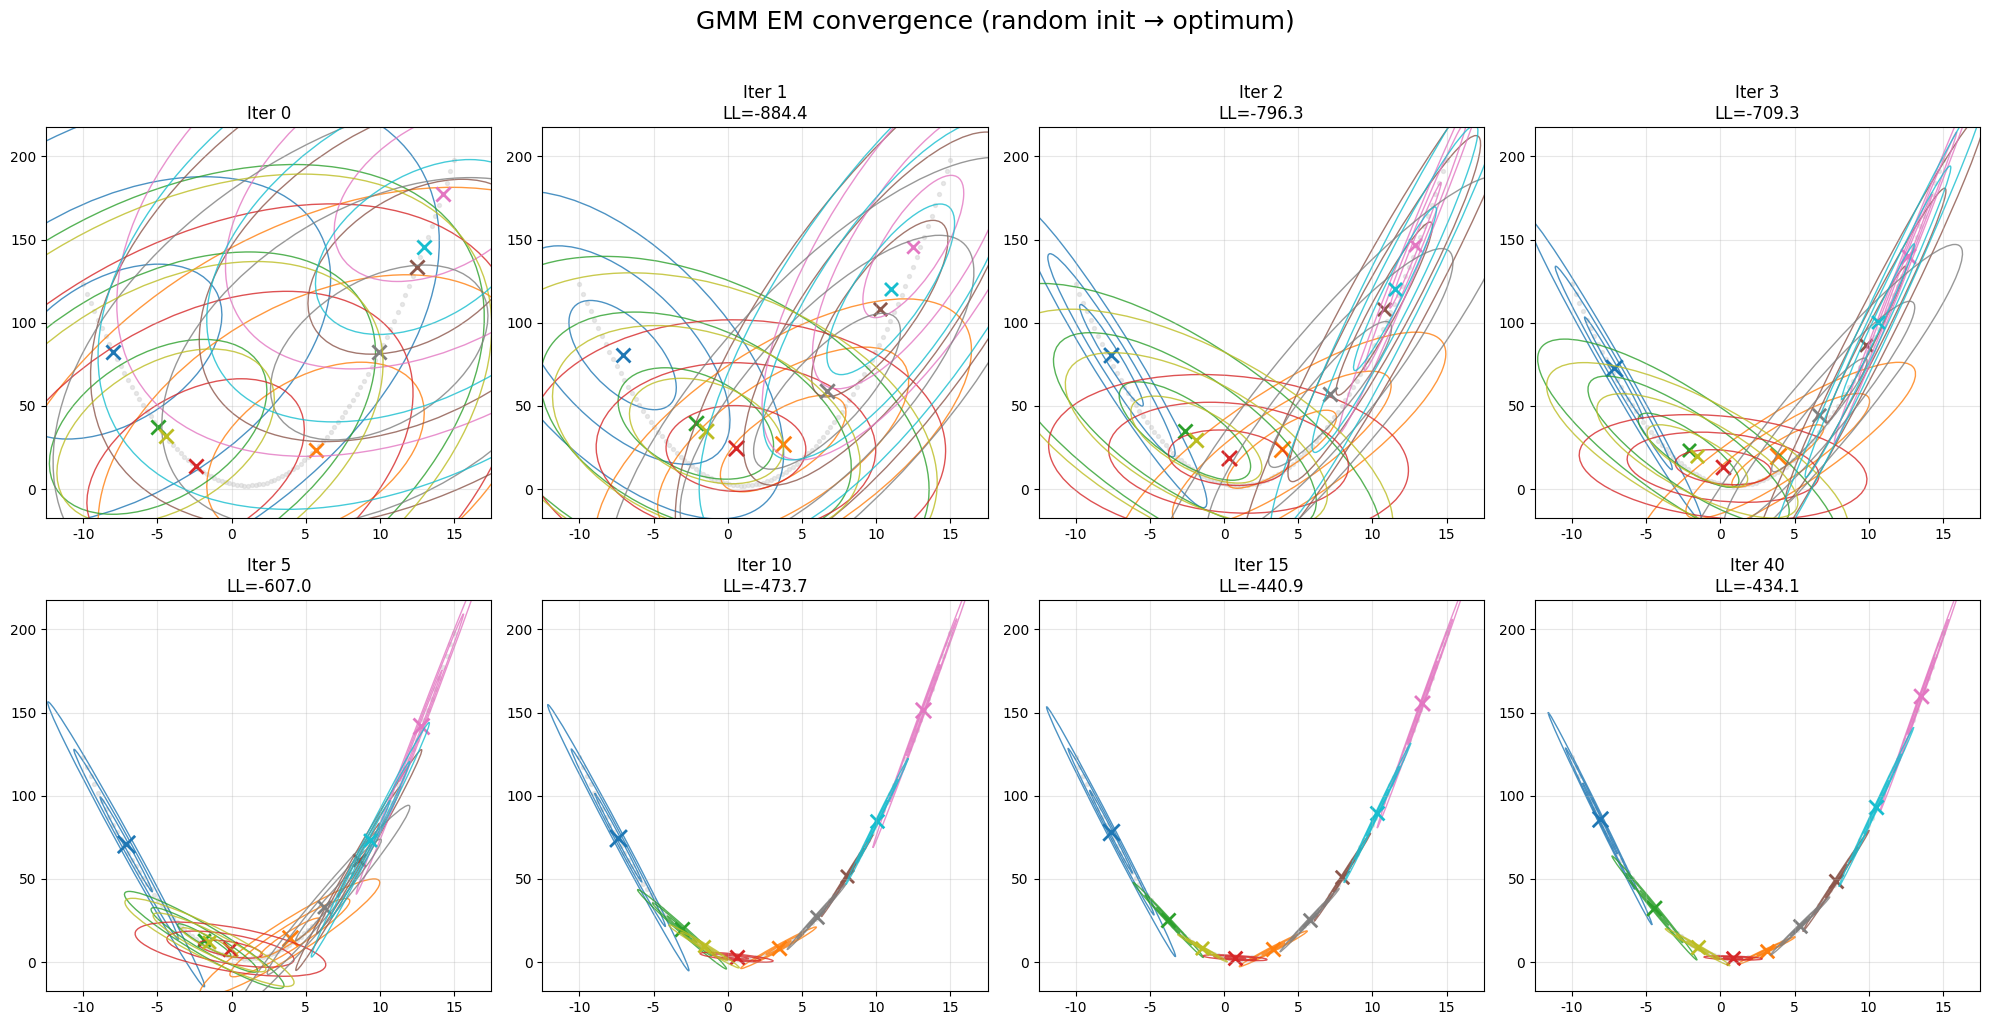

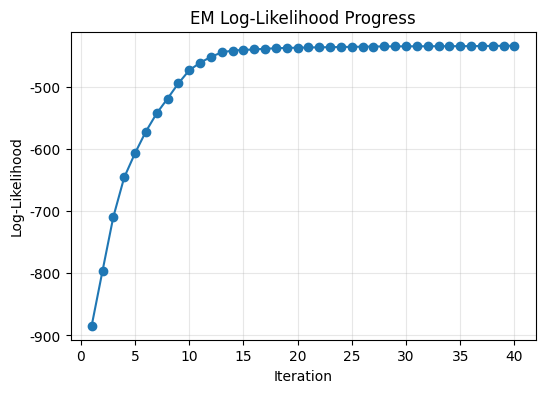

Shown iterations: [0, 1, 2, 3, 5, 10, 15, 40]
Final log-likelihood: -434.1434026186471


In [24]:
# EM convergence visualization (helper-based)
em_visualize(data, best_n_components)